In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd    
from data_collection import *

In [2]:
sentiment_data_aapl = sentiment_data('AAPL', '2020-01-01', '2024-05-01')

In [3]:
price_data_aapl = price_data('AAPL', '2020-01-01', '2024-05-01')

In [4]:
indicators_aapl = technical_indicators(price_data_aapl)

In [5]:
df_aapl = wrangle_data(sentiment_data_aapl, price_data_aapl, indicators_aapl)
df_aapl.tail()

,sentimentValue,open,high,low,close,volume,returns,SMA_short,SMA_long,EMA_short,EMA_long,std_dev,upper_band,lower_band,RSI,MACD,MACD_signal,MACD_histogram,ATR
2024-04-25,0.217,169.525,170.610,168.1511,169.89,50558329.0,0.005147,169.4825,173.5830,169.725114,173.662891,2.799306,175.081112,163.883888,45.291850,-3.937777,-4.104239,0.166462,2.916435
2024-04-26,0.032,169.880,171.340,169.1800,169.30,44838354.0,-0.003473,169.3735,173.2860,169.684627,173.491797,2.759594,174.892689,163.854311,46.892816,-3.807170,-4.044825,0.237655,2.884435
2024-04-29,0.281,173.370,176.030,173.1000,173.50,68169419.0,0.024808,169.5470,173.0788,170.047996,173.492119,2.908127,175.363253,163.730747,54.586307,-3.444123,-3.924685,0.480562,3.120685
2024-04-30,0.225,173.330,174.990,170.0000,170.33,65934776.0,-0.018271,169.6215,172.8392,170.074853,173.368114,2.908147,175.437794,163.805206,51.871389,-3.293261,-3.798400,0.505139,3.280195
2024-05-01,0.110,169.580,172.705,169.1100,169.30,50383147.0,-0.006047,169.6040,172.5940,170.001058,173.208580,2.909019,175.422039,163.785961,49.562828,-3.207523,-3.680225,0.472702,3.354945


In [6]:
from regime_detection import *

In [7]:
clustering_df_aapl = data_prep(df_aapl['close'], 3)

In [8]:
params = {'n_clusters': 2, 'linkage': 'average', 'metric': 'manhattan', 'random_state':42}
clustering = get_regimes_clustering(params)
cluster_states_aapl = clustering.fit_predict(clustering_df_aapl)

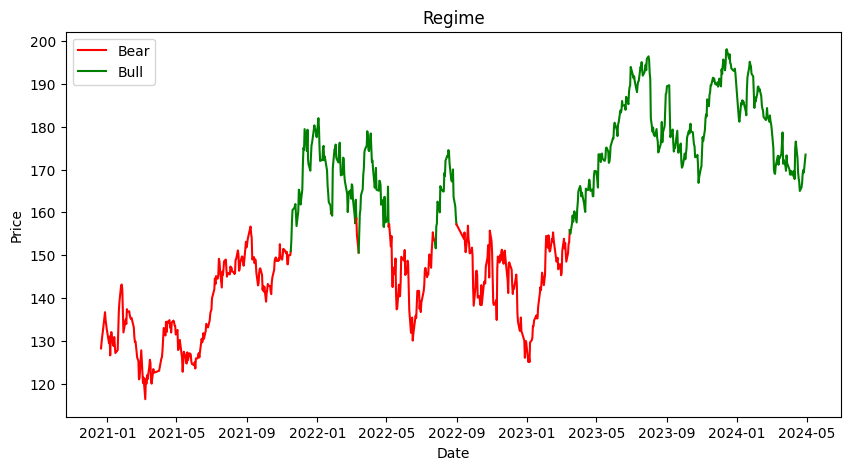

In [9]:
plot_regimes(df_aapl['close'], states=cluster_states_aapl, title='Regime')

In [10]:
from data_augmentation import *

In [11]:
X_aapl = gaf_preprocess(df_aapl)[4:]
y_aapl = cluster_states_aapl[:-1]
X_aapl.shape, y_aapl.shape

((827, 19, 19), (827,))

In [12]:
from sklearn.model_selection import train_test_split

X_train_aapl, X_test_aapl, y_train_aapl, y_test_aapl = train_test_split(X_aapl, y_aapl, shuffle=False, test_size=0.3)

In [15]:
train_loader = prepare_data_with_labels(X_train_aapl, y_train_aapl)

latent_dim = 4
lr = 0.001
epochs = 10
device = torch.device('cuda')

model = create_model(latent_dim, device)
optimizer = create_optimizer(model, lr)

for epoch in range(1, epochs + 1):
    train_model_cvae(model, train_loader, optimizer, epoch)

Train Epoch: 1 [0/578] Loss: 240.248367
Train Epoch: 1 [100/578] Loss: 0.109044
Train Epoch: 1 [200/578] Loss: 0.168467
Train Epoch: 1 [300/578] Loss: 0.102154
Train Epoch: 1 [400/578] Loss: 0.134538
Train Epoch: 1 [500/578] Loss: 0.099166
====> Epoch: 1 Average loss: 7.101435
Train Epoch: 2 [0/578] Loss: 0.056972
Train Epoch: 2 [100/578] Loss: 0.105219
Train Epoch: 2 [200/578] Loss: 0.112599
Train Epoch: 2 [300/578] Loss: 0.109421
Train Epoch: 2 [400/578] Loss: 0.135233
Train Epoch: 2 [500/578] Loss: 0.092658
====> Epoch: 2 Average loss: 0.093717
Train Epoch: 3 [0/578] Loss: 0.062525
Train Epoch: 3 [100/578] Loss: 0.102717
Train Epoch: 3 [200/578] Loss: 0.129117
Train Epoch: 3 [300/578] Loss: 0.114547
Train Epoch: 3 [400/578] Loss: 0.125588
Train Epoch: 3 [500/578] Loss: 0.100573
====> Epoch: 3 Average loss: 0.095154
Train Epoch: 4 [0/578] Loss: 0.059656
Train Epoch: 4 [100/578] Loss: 0.120627
Train Epoch: 4 [200/578] Loss: 0.094841
Train Epoch: 4 [300/578] Loss: 0.115074
Train Epoch:

In [16]:
n_samples = 2560

labels_class_0 = [0] * n_samples
synthetic_data_class_0 = synthetic_data(model, labels_class_0, n_samples)

labels_class_1 = [1] * n_samples
synthetic_data_class_1 = synthetic_data(model, labels_class_1, n_samples)

synthetic_features_aapl = np.concatenate([synthetic_data_class_0, synthetic_data_class_1])
synthetic_labels_aapl = np.array(labels_class_0 + labels_class_1)

z shape: torch.Size([2560, 4])
labels shape: torch.Size([2560])
synthetic_data shape: torch.Size([2560, 1, 19, 19])
z shape: torch.Size([2560, 4])
labels shape: torch.Size([2560])
synthetic_data shape: torch.Size([2560, 1, 19, 19])


In [20]:
synthetic_labels_aapl.shape

(5120,)

In [ ]:
from sklearn.utils import shuffle

synthetic_features_aapl, synthetic_labels_aapl =  shuffle(synthetic_features_aapl, synthetic_labels_aapl)

In [32]:
from classifier import *
import torch.nn as nn
import torch.optim as optim

In [33]:
model_aapl = TransformerModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
X_train_aapl, X_val_aapl, y_train_aapl, y_val_aapl = train_test_split(synthetic_features_aapl, synthetic_labels_aapl, random_state=42, test_size=0.3)

In [35]:
train_loader_aapl = data_prep_transformer(X_train_aapl, y_train_aapl, 32)
val_loader_aapl = data_prep_transformer(X_val_aapl, y_val_aapl, 32)

In [36]:
train_model_transformer(
    model_aapl, 
    train_loader_aapl, 
    val_loader_aapl, 
    criterion,
    optimizer,
    num_epochs=30
)

C:\Users\Abishek\anaconda3\envs\deeplearning\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/30, Train Loss: 0.7032, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 2/30, Train Loss: 0.7032, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 3/30, Train Loss: 0.7027, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 4/30, Train Loss: 0.7030, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 5/30, Train Loss: 0.7030, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 6/30, Train Loss: 0.7031, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 7/30, Train Loss: 0.7037, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 8/30, Train Loss: 0.7033, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 9/30, Train Loss: 0.7041, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 10/30, Train Loss: 0.7036, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 11/30, Train Loss: 0.7033, Train Acc: 0.4953, Val Loss: 0.6995, Val Acc: 0.5111
Epoch 12/30, Train Loss: 0.7032, Train Acc: 0.4953, Val Loss: 0